# Explaining Machine Learning

Interpretability of Machine Learning models has recently become a relevant
 research direction to more thoroughly address and mitigate the issues of
 adversarial examples and to better understand the potential flaws of the
 most recent algorithm such as Deep Neural Networks.

In this tutorial, we explore different methods to compute
 *post-hoc* explanations, which consist of analyzing a trained model to
 understand which components such as features or training prototypes are
 more relevant during the decision (classification) phase.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/maurapintor/mlsec_labs/blob/HEAD/06_explainability.ipynb)

In [1]:
%%capture --no-stderr --no-display
# NBVAL_IGNORE_OUTPUT

%pip install secml --upgrade
%pip install foolbox
%pip install transformers
%pip install shap
%pip install datasets

import secml
import foolbox

## Feature-based explanations

Feature-based explanation methods assign a value to each feature of an input
 sample depending on how relevant it is towards the classification
 decision. These relevance values are often called *attributions*.

We start with the following *gradient-based* white-box explanation methods, applied on the image classification domain:

 - **Gradient**

 Compute gradients of the output class w.r.t. the input.

 > [[baehrens2010explain]](http://www.jmlr.org/papers/volume11/baehrens10a/baehrens10a.pdf)
 > D. Baehrens, T. Schroeter, S. Harmeling, M. Kawanabe, K. Hansen,
 > K.-R.Muller, "How to explain individual classification decisions",
 > in: J. Mach. Learn. Res. 11 (2010) 1803-1831

 - **Gradient * Input**

 Decomposes the output on a specific input by backpropagating the contributions of all neurons to every feature, providing a linear approximation.

 > [[shrikumar2016not]](https://arxiv.org/pdf/1605.01713)
 > A. Shrikumar, P. Greenside, A. Shcherbina, A. Kundaje,
 > "Not just a blackbox: Learning important features through propagating
 > activation differences", 2016 arXiv:1605.01713.

 > [[melis2018explaining]](https://arxiv.org/abs/1803.03544)
 > M. Melis, D. Maiorca, B. Biggio, G. Giacinto and F. Roli,
 > "Explaining Black-box Android Malware Detection," 2018 26th European
 > Signal Processing Conference (EUSIPCO), Rome, 2018, pp. 524-528.

 - **Integrated Gradients**

  Improves the linear approximation by integrating the model’s output along the path between the input and a reference sample.

  > [[sundararajan2017axiomatic]](https://arxiv.org/pdf/1703.01365)
  > Sundararajan, Mukund, Ankur Taly, and Qiqi Yan. "Axiomatic Attribution
  > for Deep Networks." Proceedings of the 34th International Conference on
  > Machine Learning, Volume 70, JMLR. org, 2017, pp. 3319-3328.

### Training of the classifier

First, we load the MNIST dataset and we train an SVM classifier with RBF kernel.

In [2]:
random_state = 999

n_tr = 500 # number of training set samples
n_ts = 500 # number of test set samples

# load data
from secml.data.loader import CDataLoaderMNIST

loader = CDataLoaderMNIST()
tr = loader.load("training", num_samples=n_tr)
ts = loader.load("testing", num_samples=n_ts)

# normalize the data between 0 and 1
tr.X /= 255
ts.X /= 255

# creation of the multiclass classifier with RBF kernel
from secml.ml.classifiers import CClassifierSVM
from secml.ml.kernels import CKernelRBF

clf = CClassifierSVM(kernel=CKernelRBF(gamma=1e-2))

# fit the classifier
clf.fit(tr.X, tr.Y)

# compute predictions on a test set
y_pred = clf.predict(ts.X)

# evaluate the accuracy of the classifier
from secml.ml.peval.metrics import CMetricAccuracy

metric = CMetricAccuracy()
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
print(f"Accuracy on test set: {acc:.2%}")


2023-11-28 11:09:44,727 - secml.settings - INFO - New `SECML_HOME_DIR` created: /root/secml-data


INFO:secml.settings:New `SECML_HOME_DIR` created: /root/secml-data


2023-11-28 11:09:44,734 - secml.settings - INFO - Default configuration file copied to: /root/secml-data/secml.conf


INFO:secml.settings:Default configuration file copied to: /root/secml-data/secml.conf


2023-11-28 11:09:44,737 - secml.settings - INFO - New `SECML_DS_DIR` created: /root/secml-data/datasets


INFO:secml.settings:New `SECML_DS_DIR` created: /root/secml-data/datasets


2023-11-28 11:09:44,740 - secml.settings - INFO - New `SECML_MODELS_DIR` created: /root/secml-data/models


INFO:secml.settings:New `SECML_MODELS_DIR` created: /root/secml-data/models


2023-11-28 11:09:44,744 - secml.settings - INFO - New `SECML_EXP_DIR` created: /root/secml-data/experiments


INFO:secml.settings:New `SECML_EXP_DIR` created: /root/secml-data/experiments


2023-11-28 11:09:44,747 - secml.settings - INFO - New `SECML_LOGS_DIR` created: /root/secml-data/logs


INFO:secml.settings:New `SECML_LOGS_DIR` created: /root/secml-data/logs


2023-11-28 11:09:44,750 - secml.settings - INFO - New `SECML_PYTORCH_DIR` created: /root/secml-data/pytorch-data


INFO:secml.settings:New `SECML_PYTORCH_DIR` created: /root/secml-data/pytorch-data



File stored in `/root/secml-data/datasets/mnist/train-images-idx3-ubyte.gz`

File stored in `/root/secml-data/datasets/mnist/train-labels-idx1-ubyte.gz`

File stored in `/root/secml-data/datasets/mnist/t10k-images-idx3-ubyte.gz`

File stored in `/root/secml-data/datasets/mnist/t10k-labels-idx1-ubyte.gz`
Accuracy on test set: 83.80%


### Compute the explanations

The `secml.explanation` package provides different explanation methods
 as subclasses of `CExplainer`. Each explainer requires as input a
 trained classifier.

To compute the explanation on a sample, the `.explain()` method should be used.
For *gradient-based* methods, the label `y` of the class w.r.t. the explanation
 should be computed is required.

The `.explain()` method will return the relevance value associated to each
 feature of the input sample.

In [3]:
from secml.explanation import \
    CExplainerGradient, CExplainerGradientInput, CExplainerIntegratedGradients

# initialize the explainers
explainers = {
    "gradient": CExplainerGradient(clf),
    "gradient * input": CExplainerGradientInput(clf),
    "integrated gradients": CExplainerIntegratedGradients(clf)
}


In [4]:
i = 123  # test sample on which explanations should be computed
x, y = ts[i, :].X, ts[i, :].Y

print(f"Explanations for sample {i} (true class: {y.item()})")

from secml.array import CArray

# dictionary where to collect attributions of different methods
attributions = {}

for expl_name in explainers:

  # compute explanations (attributions) wrt each class
  print(f"Computing explanations using '{expl_name}'...")

  # empty array where to collect attributions values
  attr = CArray.empty(shape=(tr.num_classes, x.size))

  # loop over classes...
  for c in tr.classes:
    attr_c = explainers[expl_name].explain(x, y=c) # compute the explanation
    attr[c, :] = attr_c

  attributions[expl_name] = attr


Explanations for sample 123 (true class: 6)
Computing explanations using 'gradient'...
Computing explanations using 'gradient * input'...
Computing explanations using 'integrated gradients'...


### Visualize results

We now visualize the explanations computed using the different methods, in rows.
In columns, we show the explanations w.r.t. each different class.

Above the original tested sample, its true class label is shown.

Red (blue) pixels denote positive (negative) relevance of the corresponding
 feature wrt the specific class.

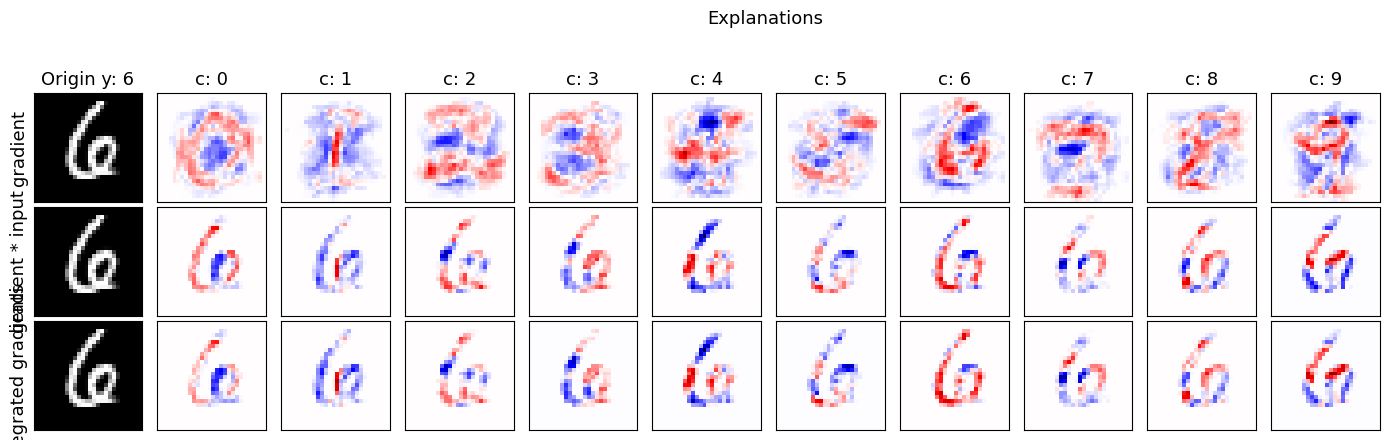

In [5]:
from secml.figure import CFigure
# only required for visualization in notebooks
%matplotlib inline

fig = CFigure(height=4.5, width=14, fontsize=13)

for i, expl_name in enumerate(explainers):

  attr = attributions[expl_name]

  sp_idx = i * (tr.num_classes+1)

  # original image
  fig.subplot(len(explainers), tr.num_classes+1, sp_idx+1)
  fig.sp.imshow(x.reshape((tr.header.img_h, tr.header.img_w)), cmap="gray")

  if i == 0:  # For the first row only
      fig.sp.title(f"Origin y: {y.item()}")

  fig.sp.ylabel(expl_name)  # label of the explainer

  fig.sp.yticks([])
  fig.sp.xticks([])

  # threshold to plot positive and negative relevance values symmetrically
  th = max(abs(attr.min()), abs(attr.max()))

  # plot explanations
  for c in tr.classes:

    fig.subplot(len(explainers), tr.num_classes+1, sp_idx+2+c)
    fig.sp.imshow(attr[c, :].reshape((tr.header.img_h, tr.header.img_w)),
                  cmap="seismic", vmin=-1*th, vmax=th)

    fig.sp.yticks([])
    fig.sp.xticks([])

    if i == 0:  # for the first row only
      fig.sp.title("c: {:}".format(c))

fig.title("Explanations", x=0.55)
fig.tight_layout(rect=[0, 0.003, 1, 0.94])
fig.show()

For both **gradient\*input** and **integrated gradients** methods we can
 observe a well defined area of positive (red) relevance for the explanation
 computed w.r.t. the digit 6. This is expected as the true class of the tested
 sample is in fact 6. Moreover, a non-zero relevance value is mainly assigned
 to the features which are present in the tested sample, which is an expected
 behavior of these explanation methods.

Conversely, the **gradient** method assigns relevance to a wider area of the
 image, even external to the actual digit. This leads to explanations which
 are in many cases difficult to interpret. For this reason, more advanced
 explanation methods are often favored.

## Exercise 1

Compute the explanations of adversarial examples.
Use the PGD L-inf attack, with eps=0.3.

In [6]:
from secml.adv.attacks.evasion import CFoolboxPGDLinf

y_target  = 2
attack = CFoolboxPGDLinf(clf, y_target=y_target,
                         lb=0.0, ub=1.0, steps=30,
                         epsilons=0.3, abs_stepsize=0.01,
                         random_start=False)

_, _, adv_ds, _ = attack.run(x, y)

pred = clf.predict(adv_ds.X).item()
print(pred)


2


## Prototype-based explanation

Prototype-based explanation methods identify the most responsible training
 points for a given prediction to explain the behavior of machine learning models.

In this tutorial, we are going to test the explanation method proposed in:

  > [[koh2017understanding]](https://arxiv.org/pdf/1703.04730)
  > Koh, Pang Wei, and Percy Liang, "Understanding black-box predictions
  > via influence functions", in: Proceedings of the 34th International
  > Conference on Machine Learning-Volume 70. JMLR. org, 2017.

It selects training samples through influence functions, that estimate how the
 model’s predictions change without a certain training sample.

### Training the classifier

As our implementation of the prototype-based explanation methods currently
 only supports binary classifiers, we load the 2-classes MNIST59 dataset and
 then we train a SVM classifier with RBF kernel.

In [7]:
n_tr = 100 # number of training set samples
n_ts = 500 # number of test set samples

digits = (5, 9) # we load only samples from those classes

# load data
loader = CDataLoaderMNIST()
tr = loader.load("training", digits=digits, num_samples=n_tr)
ts = loader.load("testing", digits=digits, num_samples=n_ts)

# normalize the data between 0 and 1
tr.X /= 255
ts.X /= 255

# creation of the multiclass classifier with RBF kernel
clf = CClassifierSVM(kernel=CKernelRBF(gamma=1e-2))

# fit the classifier
print("Training of classifier...")
clf.fit(tr.X, tr.Y)

# compute predictions on a test set
y_pred = clf.predict(ts.X)

# evaluate the accuracy of the classifier
metric = CMetricAccuracy()
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
print("Accuracy on test set: {:.2%}".format(acc))


Training of classifier...
Accuracy on test set: 96.20%


### Compute the influential training prototypes

The `CExplainerInfluenceFunctions` class provides the influence functions
 prototype-based method described previously. It requires as input the
 classifier to explain and its training set.
It also requires the identifier of the loss used to train the classier. In the
 case of SVM, it is the `hinge` loss.

To compute the influence of each training sample wrt the test samples,
 the `.explain()` method should be used.

In [8]:
from secml.explanation import CExplainerInfluenceFunctions

# initialize the explainer
explanation = CExplainerInfluenceFunctions(clf, tr, outer_loss_idx="hinge")

print("Computing influence of each training prototype on test samples...")

# compute the explanations
infl = explanation.explain(ts.X, ts.Y)


Computing influence of each training prototype on test samples...


### Visualize results

We now visualize, wrt each class, the 3 most influential training prototypes
 for two different test samples. Above each training sample, the influence
 value is shown.

In addition, above the original tested samples, the true class label is shown.

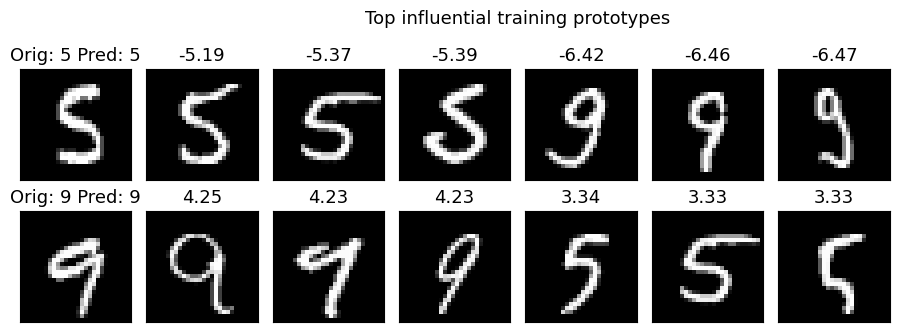

In [9]:
fig = CFigure(height=3.5, width=9, fontsize=13)

n_xc = 3  # number of training prototypes to plot per class

ts_list = (50, 100)  # test samples to evaluate

infl_argsort = infl.argsort(axis=1)  # sort influence values

for i, ts_idx in enumerate(ts_list):

    sp_idx = i * (n_xc*tr.num_classes+1)

    x, y = ts[ts_idx, :].X, ts[ts_idx, :].Y

    pred = clf.predict(x)

    # original image
    fig.subplot(len(ts_list), n_xc*tr.num_classes+1, sp_idx+1)
    fig.sp.imshow(x.reshape((tr.header.img_h, tr.header.img_w)), cmap="gray")

    fig.sp.title(f"Orig: {ts.header.y_original[y.item()]} Pred: {ts.header.y_original[pred.item()]}")

    fig.sp.yticks([])
    fig.sp.xticks([])

    tr_top = infl_argsort[ts_idx, :n_xc]
    tr_top = tr_top.append(infl_argsort[ts_idx, -n_xc:])

    # plot top influential training prototypes
    for j, tr_idx in enumerate(tr_top[::-1]):  # sort highest first
        fig.subplot(len(ts_list), n_xc*tr.num_classes+1, sp_idx+2+j)
        fig.sp.imshow(tr.X[tr_idx, :].reshape((tr.header.img_h, tr.header.img_w)), cmap="gray")

        fig.sp.title(f"{infl[ts_idx, tr_idx].item():.2f}")

        fig.sp.yticks([])
        fig.sp.xticks([])

fig.title("Top influential training prototypes", x=0.57)
fig.tight_layout()
fig.show()


For both the tested samples we can observe a direct correspondence between
 the most influencial training prototypes and their true class. Specifically,
 the samples having highest (lowest) influence values are (are not) from
 the same true class of the tested samples.

## Exercise 2
Visualize the prototypes for a poisoned classifier.

In [10]:
# TODO write your code here

## Explaining language models

In the last part of this tutorial we switch to the Natural Language Processing domain, focusing on transformer-based architectures. In particular we consider [BERT](https://arxiv.org/abs/1810.04805), a Large Language Model (LLM) pre-trained on a large text corpus which can be quickly fine-tuned on a wide range of downstream tasks, by attaching a different layer on top of the representation space.

We will rely to the [Hugging Face](https://huggingface.co) `transformers` library, which provides APIs, tools, and an open model zoo to easily download and load available models.

For this tutorial we select a text classification model that tries to infer emotions, among six different classes (sadness, joy, love, anger, fear, surprise). We start loading the [pre-trained model](https://huggingface.co/nateraw/bert-base-uncased-emotion) from Hugging Face.

In [11]:
import transformers


# load the model and tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(
    "nateraw/bert-base-uncased-emotion", use_fast=True
)
model = transformers.AutoModelForSequenceClassification.from_pretrained(
    "nateraw/bert-base-uncased-emotion"
).cuda()

# build a pipeline object to do predictions
pred = transformers.pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0,
    return_all_scores=True,  # observe the model’s behavior for all classes, not just the top output
)


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

  warnings.warn(



### SHAP

To provide local explanations we use [SHAP](https://github.com/shap/shap) (SHapley Additive exPlanations), a black-box unified framework based on Shapley values, a method from cooperative game theory that assigns each feature an importance value for a particular prediction.

> [[lundberg2017shap]](https://papers.nips.cc/paper_files/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf) Scott M. Lundberg and Su-In Lee. 2017. A unified approach to interpreting model predictions. In Proceedings of the 31st International Conference on Neural Information Processing Systems (NIPS'17). Curran Associates Inc., Red Hook, NY, USA, 4768-4777.

Among the available techniques implemented in SHAP, we leverage the `Partition` method, which computes Shapley values recursively through a hierarchy of features by masking (i.e., removing) features from the input sample during
the computation of the explanation and evaluating the model outputs, capturing the correlation between input features.

SHAP fully support Hugging Face transformers library, so that we only have to pass the classifier pipeline to the explainer.

In [12]:
import shap


# write a sentence
data = ["I am not happy, I'm sad rather than happy"]

# we first classify it
print(pred(data)[0])

# initialize the explainer
explainer = shap.Explainer(pred)

# compute the attributions
shap_values = explainer(data)


[{'label': 'sadness', 'score': 0.10323923826217651}, {'label': 'joy', 'score': 0.8760589361190796}, {'label': 'love', 'score': 0.013690270483493805}, {'label': 'anger', 'score': 0.004320166073739529}, {'label': 'fear', 'score': 0.0016321288421750069}, {'label': 'surprise', 'score': 0.0010593002662062645}]


### Visualize force plots

Once the SHAP values are computed, we can visualize feature attributions towards individual classes through force plots.

The base value is what the model outputs when the entire input text is masked, while $f_{class}(inputs)$ is the output of the model for the full original input. The SHAP values explain in an additive way how the impact of unmasking each word changes the model output from the base value (where the entire input is masked) to the final prediction value.

In [13]:
shap.plots.text(shap_values)


### Global explanations

If we compute the local explanations on a set of samples and aggregate the results, we can obtain the most relevant features that influence the behavior of the model on that dataset.

We first load an emotion dataset from Hugging Face and randomly pick 10 samples, then compute SHAP values on them.

In [14]:
import datasets
import pandas as pd


# load the emotion dataset
dataset = datasets.load_dataset("emotion", split="train")
data = pd.DataFrame({"text": dataset["text"], "emotion": dataset["label"]})

# get attributions for ten random samples
shap_values = explainer(data.sample(10, random_state=random_state)["text"])

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 5/10 [00:15<00:11,  2.27s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 6/10 [00:20<00:14,  3.50s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 7/10 [00:28<00:15,  5.18s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 9/10 [00:39<00:05,  5.16s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 11it [00:51,  6.39s/it]


### Visualize results

We can plot the most relevant features that impact a single class through a bar chart, after averaging the attributions for the selected class.

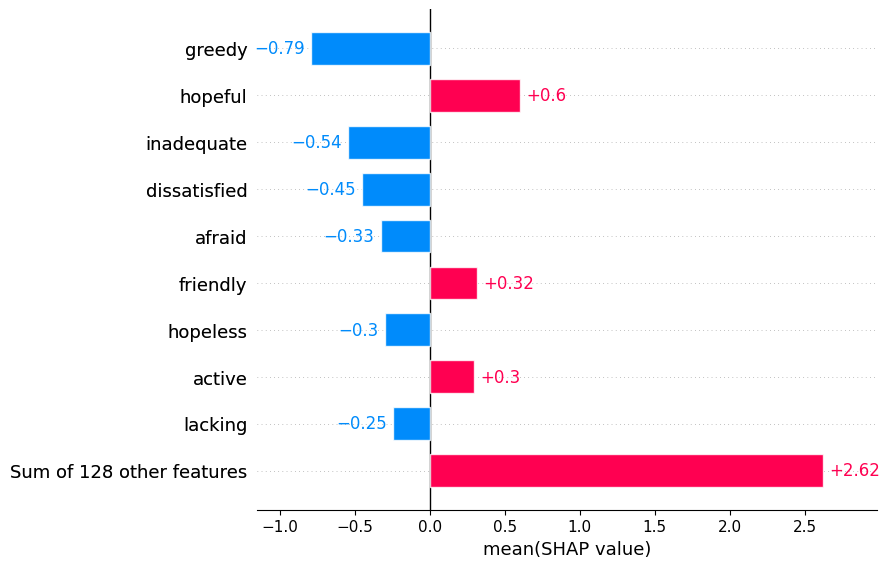

In [15]:
red_shap_values = shap_values[:, :, "joy"].mean(0)

shap.plots.bar(red_shap_values)

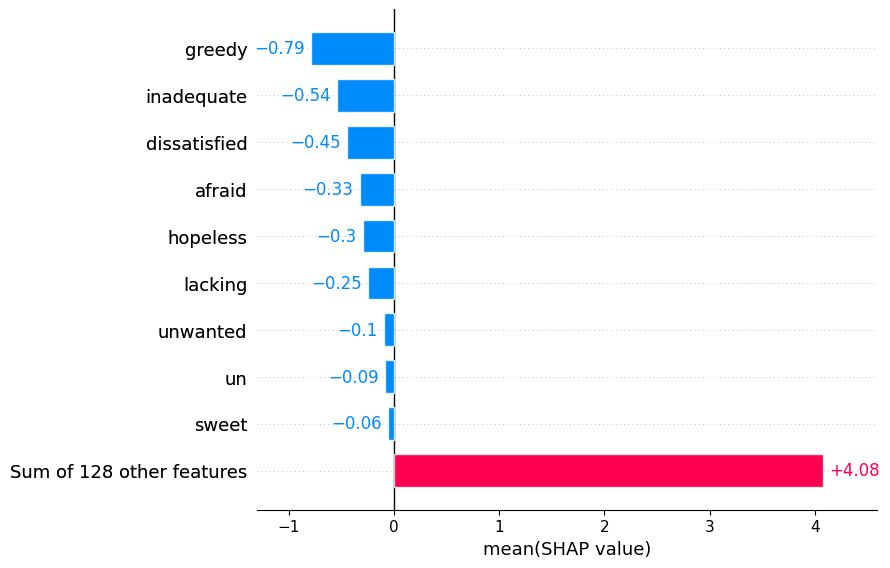

In [16]:
# we can sort the bar chart in decending order
shap.plots.bar(red_shap_values, order=shap.Explanation.argsort)

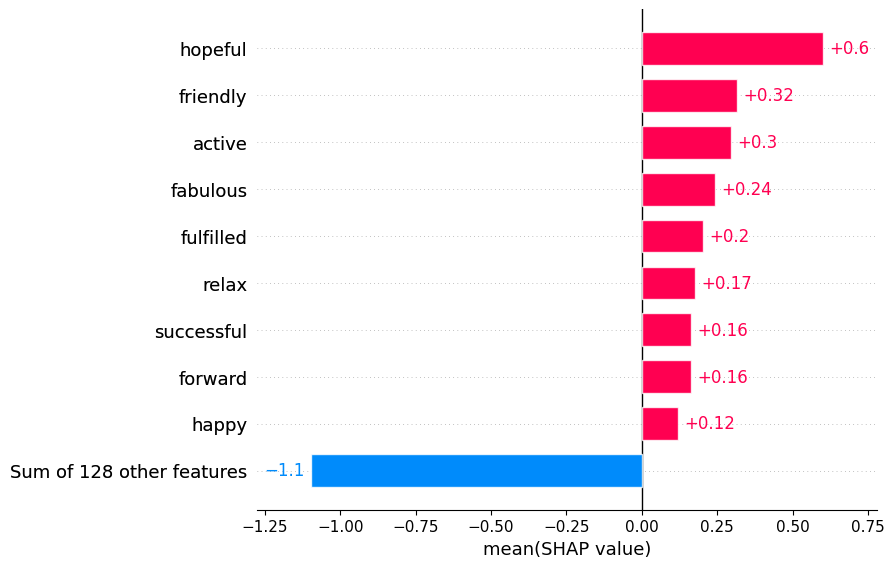

In [17]:
# ...or acending order
shap.plots.bar(red_shap_values, order=shap.Explanation.argsort.flip)
